In [1]:
import torch
from ultralytics import YOLO
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import shutil

# Cek apakah GPU terdeteksi
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: Masih menggunakan CPU! Cek instalasi PyTorch kamu.")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# --- KONFIGURASI PATH LOKAL ---
# Ganti path ini sesuai lokasi di laptop kamu
# Gunakan huruf 'r' di depan string agar backslash windows aman
dataset_root_dir = r"C:\Users\Nicotin\uas_emotion\Emotion UAS\Dataset\emotion"
my_face_dir      = r"C:\Users\Nicotin\uas_emotion\Emotion UAS\Dataset\foto_saya"

print(f"Dataset Root: {dataset_root_dir}")

Dataset Root: C:\Users\Nicotin\uas_emotion\Emotion UAS\Dataset\emotion


In [3]:
# --- MERGE DATASET ---
print("Sedang menggabungkan foto wajah kamu ke dataset utama...")

subsets = ['train', 'test']
emotions = ['happy', 'sad', 'neutral', 'angry']
total_copied = 0

for subset in subsets:
    for emo in emotions:
        src_path = os.path.join(my_face_dir, subset, emo)
        dst_path = os.path.join(dataset_root_dir, subset, emo)

        if os.path.exists(src_path) and os.path.exists(dst_path):
            # Ambil semua jenis gambar
            files = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
                files.extend(glob.glob(os.path.join(src_path, ext)))

            for f in files:
                filename = os.path.basename(f)
                new_name = f"MYFACE_{subset}_{filename}"
                dest_file = os.path.join(dst_path, new_name)

                if not os.path.exists(dest_file):
                    shutil.copy(f, dest_file)
                    total_copied += 1

print(f"SELESAI! Total {total_copied} foto baru ditambahkan.")

Sedang menggabungkan foto wajah kamu ke dataset utama...
SELESAI! Total 96 foto baru ditambahkan.


In [4]:
# --- PENGECEKAN DATA ---
# Path yang digunakan untuk training adalah folder UTAMA
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# Cek jumlah data per kelas
if os.path.exists(train_dir):
    classes = os.listdir(train_dir)
    print(f"Classes found: {classes}")
    for c in classes:
        c_path = os.path.join(train_dir, c)
        if os.path.isdir(c_path):
            n_train = len(os.listdir(c_path))
            print(f" - {c}: {n_train} images")
else:
    print("ERROR: Folder train tidak ditemukan! Cek path Google Drive kamu.")

Classes found: ['angry', 'happy', 'neutral', 'sad']
 - angry: 4015 images
 - happy: 7235 images
 - neutral: 4985 images
 - sad: 4850 images


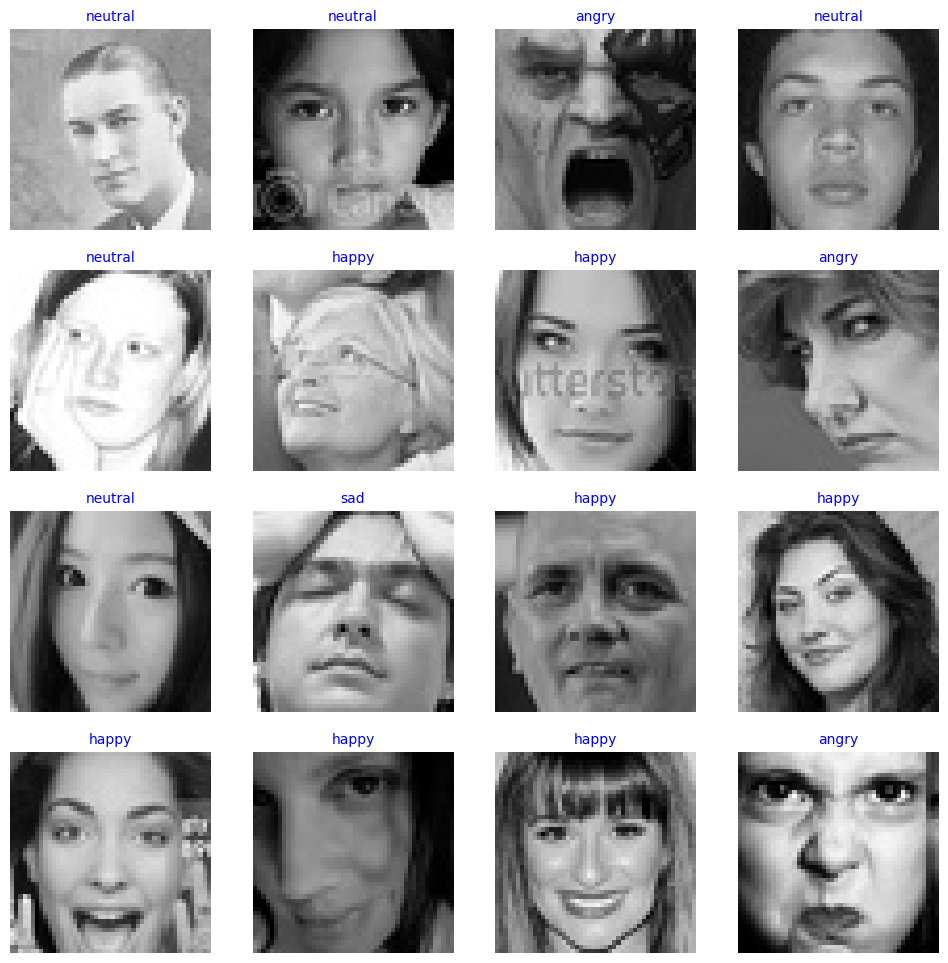

In [5]:
# --- SHOW IMAGES ---
if os.path.exists(train_dir):
    plt.figure(figsize=(12, 12))
    # Ambil sample gambar (termasuk subfolder)
    all_images = glob.glob(os.path.join(train_dir, '*', '*'))
    # Filter hanya file gambar valid
    all_images = [x for x in all_images if x.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(all_images) > 0:
        np.random.shuffle(all_images)
        sample_images = all_images[:16]

        for i, img_path in enumerate(sample_images):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = os.path.basename(os.path.dirname(img_path))

                plt.subplot(4, 4, i + 1)
                plt.imshow(img)
                plt.title(label, color="blue", fontsize=10)
                plt.axis("off")
            except:
                pass
        plt.show()
    else:
        print("Tidak ada gambar ditemukan di folder train.")

In [6]:
# --- TRAINING ---
from ultralytics import YOLO

# 1. Load Model
model = YOLO('yolo11m-cls.pt')

# 2. Train
# workers=0 sangat PENTING untuk Windows Local
results = model.train(data=dataset_root_dir, 
                      epochs=100,       # Target maksimal 100 epoch
                      patience=10,      # <--- INI KUNCINYA (Early Stopping)
                      imgsz=64, 
                      batch=16, 
                      device=0,         # Pakai GPU 0
                      workers=0,        # Wajib 0 kalau di Windows
                      save=True,        # Pastikan simpan model terbaik
                      name='yolo_emotion_local_100')

New https://pypi.org/project/ultralytics/8.3.240 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.239  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Nicotin\uas_emotion\Emotion UAS\Dataset\emotion, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-cls.pt, momentum=0.937, mosaic=1.0, multi_sc


--- MULAI EVALUASI ---
Sedang menghitung Confusion Matrix...

✅ Final Accuracy: 76.17%

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.68      0.71       962
       happy       0.90      0.90      0.90      1778
     neutral       0.65      0.75      0.70      1237
         sad       0.69      0.63      0.66      1251

    accuracy                           0.76      5228
   macro avg       0.75      0.74      0.74      5228
weighted avg       0.76      0.76      0.76      5228



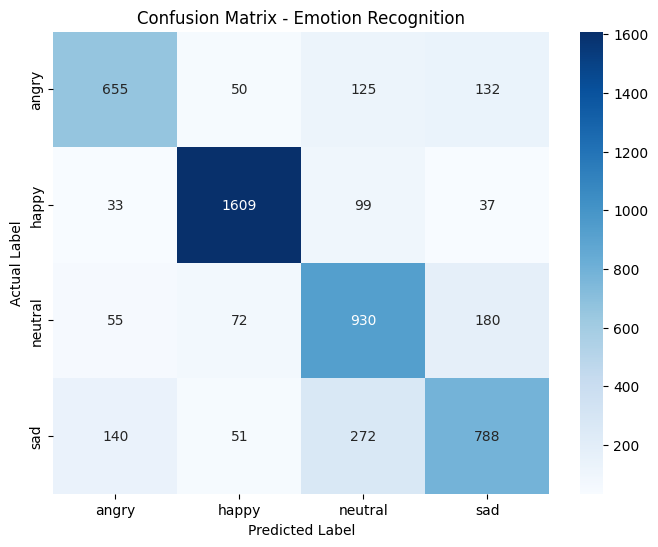

Model tersimpan di: C:\Users\Nicotin\uas_emotion\Emotion UAS\my_best_emotion_model_local.pt


In [12]:
# --- EVALUASI ---
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from ultralytics import YOLO

print("\n--- MULAI EVALUASI ---")

# Load model terbaik hasil training
# Pastikan 'results' masih tersimpan di memori, kalau error, ganti path manual:
# best_model_path = r"C:\path\to\your\runs\classify\train_result\weights\best.pt"
best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
val_model = YOLO(best_model_path)

# Path dataset test
test_dir = os.path.join(dataset_root_dir, 'test')
class_names = sorted(os.listdir(test_dir)) # Pastikan urutan folder = urutan kelas

y_true = []
y_pred = []

print("Sedang menghitung Confusion Matrix...")

# Loop manual ke folder test agar kita bisa bandingkan label asli vs prediksi
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        # Ambil semua gambar
        images = glob.glob(os.path.join(class_path, '*.*'))
        # Filter cuma gambar jpg/png
        images = [x for x in images if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_path in images:
            # Prediksi
            res = val_model(img_path, verbose=False)
            pred_idx = res[0].probs.top1  # Hasil prediksi (angka)
            
            y_true.append(class_idx)      # Label Asli (dari nama folder)
            y_pred.append(pred_idx)       # Label Prediksi (dari model)

# Hitung Metrics (Sekarang pasti bisa karena sudah di-import)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\n✅ Final Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Gambar Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Emotion Recognition')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Save model ke folder yang mudah dicari
best_model_path = os.path.join(results.save_dir, 'weights', 'best.pt')
target_path = 'my_best_emotion_model_local.pt'
shutil.copy(best_model_path, target_path)

print(f"Model tersimpan di: {os.path.abspath(target_path)}")

# Load ulang
emotion_model = YOLO(target_path)

In [16]:
# --- WEBCAM REAL-TIME (LOCAL NATIVE) ---
import cv2
import torch
from ultralytics import YOLO

# Load Face Detector
face_detector = YOLO('yolo11m.pt') 

# Load Model Emosi (Pastikan sudah diload sebelumnya atau uncomment baris ini)
# emotion_model = YOLO('my_best_emotion_model_local.pt')

# Buka Kamera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Kamera tidak terdeteksi!")
else:
    print("Kamera terbuka! Tekan 'q' untuk keluar.")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Konfigurasi Threshold
CONFIDENCE_THRESHOLD = 0.4

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # --- FIX MIRRORING ---
    # Flip frame secara horizontal (1 = horizontal flip)
    frame = cv2.flip(frame, 1)  # <--- INI BARIS TAMBAHANNYA
    
    # 1. Deteksi Wajah
    det_results = face_detector(frame, classes=[0], conf=0.4, verbose=False)
    
    for r in det_results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            # Crop Wajah
            h, w, _ = frame.shape
            face_img = frame[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]
            
            if face_img.size > 0:
                try:
                    # 2. Klasifikasi Emosi
                    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                    cls_results = emotion_model(face_rgb, verbose=False)
                    
                    top1_idx = cls_results[0].probs.top1
                    conf = cls_results[0].probs.top1conf.item()
                    label_name = cls_results[0].names[top1_idx]
                    
                    # Logika Threshold
                    if conf > CONFIDENCE_THRESHOLD:
                        label_text = f"{label_name} ({conf*100:.0f}%)"
                        box_color = (0, 255, 0)
                    else:
                        label_text = f"Unsure ({conf*100:.0f}%)"
                        box_color = (0, 165, 255)

                    # Gambar Kotak & Label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
                    (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(frame, (x1, y1 - 25), (x1 + text_w, y1), box_color, -1)
                    cv2.putText(frame, label_text, (x1, y1 - 7), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                                
                except Exception as e:
                    pass

    # Tampilkan Window
    cv2.imshow('YOLO Emotion Detection (No Mirror)', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Kamera terbuka! Tekan 'q' untuk keluar.
